In [15]:
from annoy import AnnoyIndex
from navec import Navec
import json
from transformers import T5ForConditionalGeneration, T5Tokenizer
from random import choice
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
os.environ["SYNONIMS"] = "../../checkpoints/synonims.ann"
os.environ["EMBEDDINGS"] = "../../checkpoints/navec_hudlit_v1_12B_500K_300d_100q.tar"
os.environ["WORDS"] = "../../checkpoints/words.json"


class Augmentator(object):
    """Объект для расширения числа данных через замены слова на синонимы, перемешивание слов, удаления слов,
    добавления слов, обратный перевод """

    def __init__(self):
        self.annoy = AnnoyIndex(300, "euclidean")
        self.annoy.load(os.environ["SYNONIMS"])
        self.navec = Navec.load(os.environ["EMBEDDINGS"])
        with open(os.environ["WORDS"]) as f:
            self.words = json.load(f)
        self.model = T5ForConditionalGeneration.from_pretrained('cointegrated/rut5-base-paraphraser')
        self.tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-base-paraphraser')
        self.model.cpu()
        self.model.eval()

    def find_close_word(self, word: str) -> str:
        """Находит для слова синоним через annoy поиска ближайшего эмбеддинга в Natasha"""
        if word not in self.navec:
            return word
        close_words_id = self.annoy.get_nns_by_vector(self.navec[word], 6)[1:6]
        return self.words[choice(close_words_id)]

    def deep_augment(self, text: str, beams=5, grams=4, do_sample=False) -> str:
        """Нейросетевая аугментация"""
        x = self.tokenizer(text, return_tensors='pt', padding=True).to(self.model.device)
        max_size = int(x.input_ids.shape[1] * 1.5 + 10)
        out = self.model.generate(**x, encoder_no_repeat_ngram_size=grams, num_beams=beams, max_length=max_size,
                                  do_sample=do_sample)
        return self.tokenizer.decode(out[0], skip_special_tokens=True)

    def augment(self, text: str) -> str:
        """Кастомная аугментация"""
        text = text.split()
        for i in range(len(text)):
            if choice(range(2)) == 0:
                text[i] = self.find_close_word(text[i])
            if i > 0 and choice(range(5)) == 0:
                text[i - 1], text[i] = text[i], text[i - 1]
            if choice(range(15)) == 0:
                text[i] = ""
            if choice(range(8)) == 0:
                text[i] = text[i] + " и " + self.find_close_word(text[i])
        text = " ".join(text)
        return text


In [3]:
a = Augmentator()

In [4]:
df = pd.read_csv("../../ml/data/preprocess_dataset.csv").dropna()

In [5]:
df = df[df["class"] <= 39]
df = df.reset_index().drop(columns=["index"])

In [6]:
classes_count = [i for i in df.groupby("class").count()["text"] if i > 2]

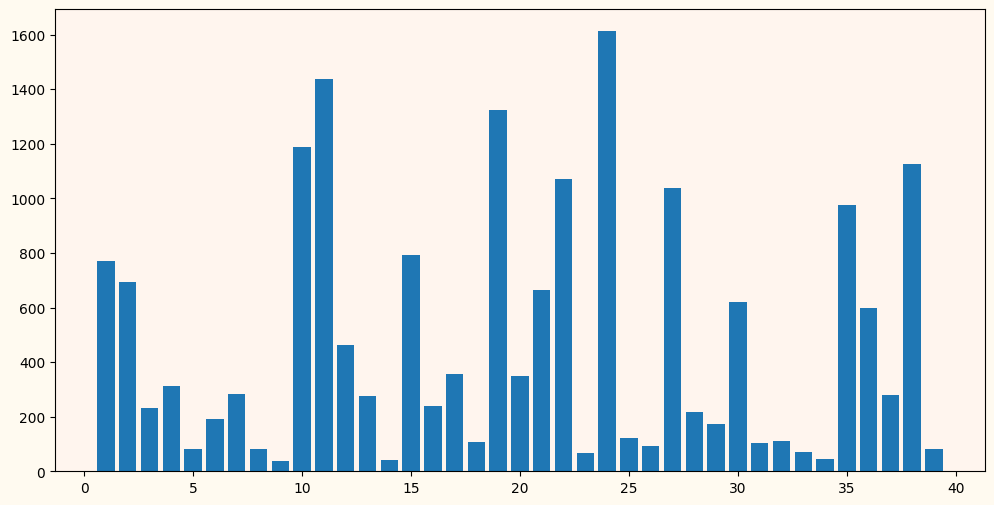

In [7]:
x = range(1, 40)
y = classes_count

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

In [8]:
needen_improve = [int(900 / classes_count[i]) + 1 for i in range(39)]
needen_improve = [min(i, 10) for i in needen_improve]

In [9]:
k = len(df)
for i in tqdm(range(k)):
    text, label = df.loc[i]["text"], df.loc[i]["class"]
    if classes_count[label - 1] < 1000:
        for j in range(needen_improve[label - 1]):
            classes_count[label - 1] += 1
            df.loc[k] = [a.augment(text), "-", label, 1]
            k += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18322/18322 [02:48<00:00, 108.86it/s]


In [10]:
classes_count = [i for i in df.groupby("class").count()["text"] if i > 2]

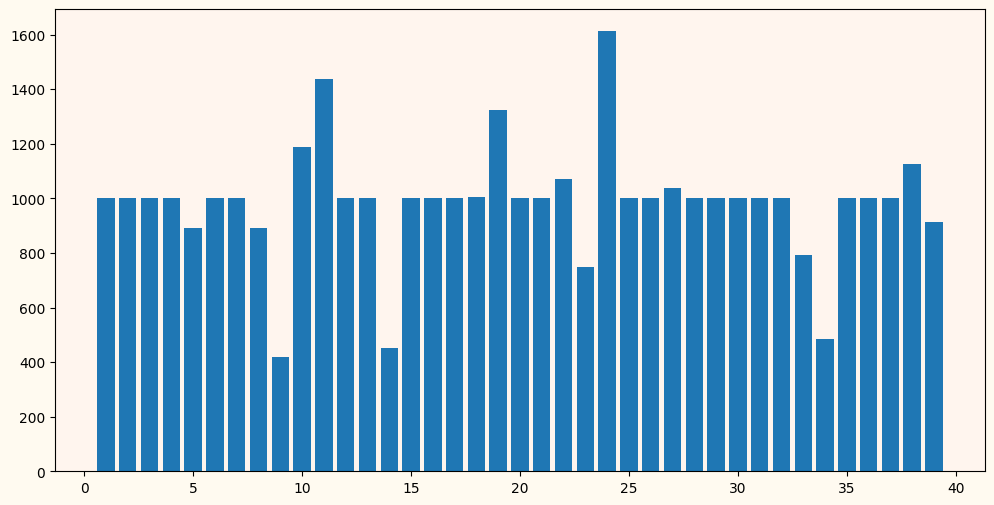

In [11]:
x = range(1, 40)
y = classes_count

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

In [13]:
df.to_csv("../../ml/data/preprocess_augmented_dataset.csv")

In [17]:
df = df[["text", "class"]]

In [19]:
train, test = train_test_split(df, train_size=0.8)

In [21]:
vectorizer = TfidfVectorizer().fit(df["text"])

In [23]:
train_x = vectorizer.transform(train["text"])
test_x = vectorizer.transform(test["text"])
train_y = train["class"]
test_y = test["class"]

In [40]:
train = {"precision": [], "recall": [], "accuracy": []}
test = {"precision": [], "recall": [], "accuracy": []}
for max_depth in tqdm(range(1, 50)):
    model = RandomForestClassifier(n_estimators=25, max_depth=max_depth).fit(train_x, train_y)
    y_pred = model.predict(train_x)
    train["precision"].append(precision_score(train_y, y_pred, average="micro"))
    train["recall"].append(recall_score(train_y, y_pred, average="micro"))
    train["accuracy"].append(accuracy_score(train_y, y_pred))
    y_pred = model.predict(test_x)
    test["precision"].append(precision_score(test_y, y_pred, average="micro"))
    test["recall"].append(recall_score(test_y, y_pred, average="micro"))
    test["accuracy"].append(accuracy_score(test_y, y_pred))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [12:03<00:00, 14.76s/it]


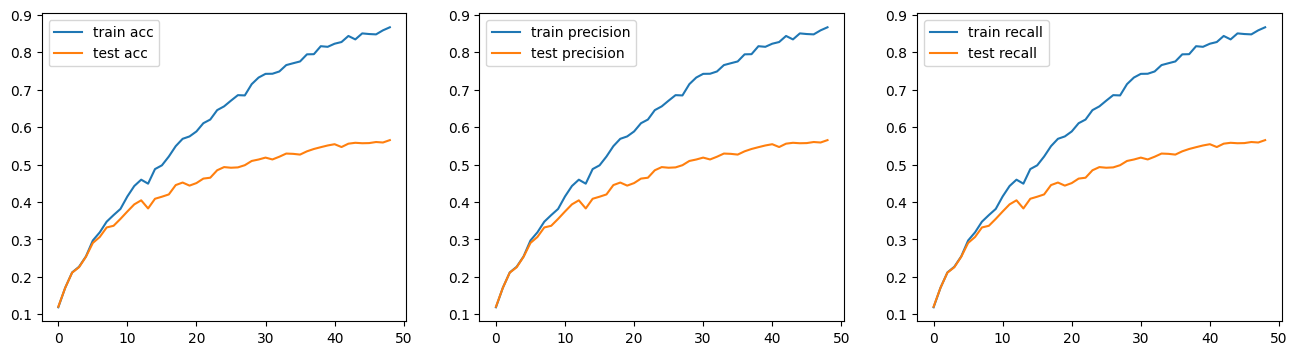

In [45]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(train["accuracy"], label="train acc")
plt.plot(test["accuracy"], label="test acc")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train["precision"], label="train precision")
plt.plot(test["precision"], label="test precision")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train["recall"], label="train recall")
plt.plot(test["recall"], label="test recall")

plt.legend()
plt.show()

In [46]:
import pickle

In [47]:
pickle.dump(vectorizer, open("../../checkpoints/vectorizer.pickle", "wb"))

In [49]:
pickle.dump(model, open("../../checkpoints/random_forest.pkl", "wb"))